In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from gears import PertData
from gears.inference import evaluate, compute_metrics, deeper_analysis

pert_data = PertData('./data')
pert_data.load(data_name = 'norman')
pert_data.prepare_split(split = 'simulation', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

from gears import GEARS
gears_model = GEARS(pert_data, device = 'cuda:7')

## train a uncertainty-aware model, specify uncertainty to True
#gears_model.model_initialize(uncertainty = True)
#gears_model.train(epochs = 20)
#gears_model.save_model('gears_unc')

## load a pretrained uncertainty model
gears_model.load_pretrained('pertnet_unc')

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


In [2]:
test_res = evaluate(gears_model.dataloader['test_loader'], gears_model.model, gears_model.config['uncertainty'], gears_model.device)
test_metrics, test_pert_res = compute_metrics(test_res)
out = deeper_analysis(gears_model.adata, test_res)

In [3]:
pert2unc = pd.DataFrame(tuple(zip(test_res['pert_cat'], np.mean(test_res['logvar'], axis = 1)))).groupby(0).agg(np.mean)
pert2unc = dict(zip(pert2unc.index.values, pert2unc.values))

metric = 'pearson_delta'
stats_summary = [np.exp(-pert2unc[i][0]) for i in test_pert_res.keys() if metric in out[i]]
metric_summary = [out[i][metric] for i in test_pert_res.keys() if metric in out[i]]
print(pearsonr(stats_summary, metric_summary))

(-0.5460394326430713, 2.3041185482482106e-10)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

font_dirs = ["./"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set( font = "Helvetica" )

sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)
pal = sns.color_palette("Set2").as_hex()

def plot(stats_summary, metric_summary):

    ax = sns.regplot(np.array(stats_summary),
                    np.array(metric_summary), 
                    color = pal[2],
                     ci = None
                    )

    sns.despine()

    plt.ylabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.xlabel("Predicted Uncertainty",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('uncertainty.pdf', bbox_inches='tight')
    
    plt.show()
    
    top = np.quantile(np.array(list(pert2unc.values())), 0.95)

    m = 'pearson_delta'
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)], hist = False, color = "black")
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)], hist = False, color = "Red")

    print('---- ' + m + '----')
    total_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)])
    after_filter_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)])
    print('Total Mean: ' + str(total_mean))
    print('After uncertainty filter Mean: ' + str(after_filter_mean))
    print('Enrichment: ' + str((after_filter_mean - total_mean)/total_mean))

    sns.despine()
    ax.set_xlim((-0.24,1.24))
    plt.xlabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.ylabel("Density of Perturbations",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('prioritize_uncertainty.pdf', bbox_inches='tight')
    plt.show()


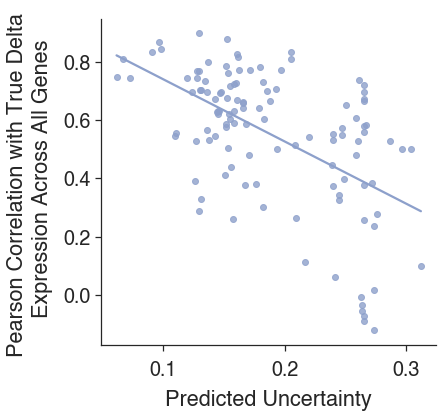

---- pearson_delta----
Total Mean: 0.5379396545929792
After uncertainty filter Mean: 0.8077536054445641
Enrichment: 0.501569178899321


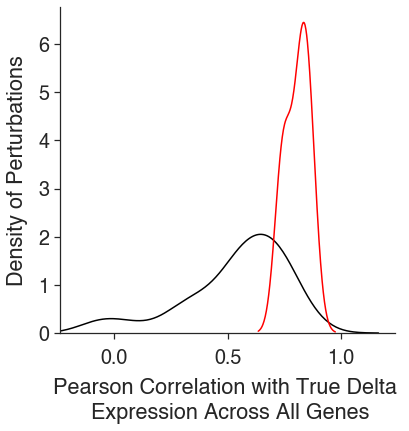

In [5]:
plot(stats_summary, metric_summary)